# Hyper-Parameters Optim

In [1]:
import numpy as np

In [2]:
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [3]:
def create_Xt_Yt(X, y, percentage=0.95):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

In [4]:
def remove_nan_examples(data):
    newX = []
    for i in range(len(data)):
        if np.isnan(data[i]).any() == False:
            newX.append(data[i])
    return newX

In [6]:
import numpy as np
import json
import glob


import pandas as pd
import matplotlib.pylab as plt

In [7]:
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute, Reshape
from keras.layers import Merge, Input, concatenate
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers import Convolution1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, RepeatVector, AveragePooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.constraints import *
from keras import regularizers
from keras import losses

from keras import backend as K
import seaborn as sns
sns.despine()

Using TensorFlow backend.


In [9]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score
import sys

In [10]:
STEP = 1
FORECAST = 10

In [53]:
data_original = pd.read_csv('dataset/700_data_from_IB_1day.csv')
data_original = data_original.dropna()

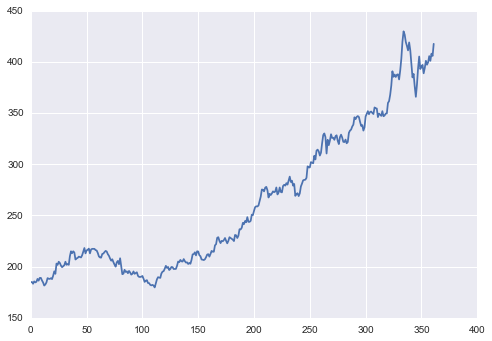

In [54]:
plt.plot(data_original['close'])
plt.show()

In [59]:
def prepare_data(window):

    openp = data_original.loc[:, 'open'].tolist()[1:]
    highp = data_original.loc[:, 'high'].tolist()[1:]
    lowp = data_original.loc[:, 'low'].tolist()[1:]
    closep = data_original.loc[:, 'close'].tolist()[1:]
    volumep = data_original.loc[:, 'volume'].tolist()[1:]
    volumecp = data_original.loc[:, 'volume'].tolist()[1:]

    volatility = pd.DataFrame(closep).rolling(window).std().values.tolist()
    volatility = [v[0] for v in volatility]

    X, Y = [], []
    for i in range(0, len(data_original), STEP): 
        try:
            o = openp[i:i+window]
            h = highp[i:i+window]
            l = lowp[i:i+window]
            c = closep[i:i+window]
            v = volumep[i:i+window]
            vc = volumecp[i:i+window]
            volat = volatility[i:i+window]

            o = (np.array(o) - np.mean(o)) / np.std(o)
            h = (np.array(h) - np.mean(h)) / np.std(h)
            l = (np.array(l) - np.mean(l)) / np.std(l)
            c = (np.array(c) - np.mean(c)) / np.std(c)
            v = (np.array(v) - np.mean(v)) / np.std(v)
            vc = (np.array(vc) - np.mean(vc)) / np.std(vc)
            volat = (np.array(volat) - np.mean(volat)) / np.std(volat)

            x_i = np.column_stack((o, h, l, c, v, vc, volat))
            x_i = x_i.flatten()

            y_i = (closep[i+window+FORECAST] - closep[i+window]) / closep[i+window]

            if np.isnan(x_i).any():
                continue

        except Exception as e:
            break

        X.append(x_i)
        Y.append(y_i)

    X, Y = np.array(X), np.array(Y)
    X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)
    return X_train, X_test, Y_train, Y_test


In [60]:
def experiment(params):
    X_train, X_test, Y_train, Y_test = prepare_data(params['window'])

    print ('Trying', params)


    try:
        main_input = Input(shape=(len(X_train[0]), ), name='main_input')
        x = Dense(params['units1'], activation=params['activation'])(main_input)
        x = Dense(params['units2'], activation=params['activation'])(x)
        x = Dense(params['units3'], activation=params['activation'])(x)

        output = Dense(1, activation = "linear", name = "out")(x)
        final_model = Model(inputs=[main_input], outputs=[output])
        opt = Adam(lr=params['lr'])

        final_model.compile(optimizer=opt,  loss=params['loss'])

        history = final_model.fit(X_train, Y_train, 
                  epochs = 5, 
                  batch_size = 256, 
                  verbose=1, 
                  validation_data=(X_test, Y_test),
                  shuffle=True)

        pred = final_model.predict(X_test)

    except:
        print ('Something happened')
        print ('-' * 10)

        return {'loss': 999999, 'status': STATUS_OK}


    predicted = pred
    original = Y_test

    mse = np.mean(np.square(predicted - original))    

    if np.isnan(mse):
        print ('NaN happened')
        print ('-' * 10)
        return {'loss': 999999, 'status': STATUS_OK}

    print (mse)
    print ('-' * 10)

    sys.stdout.flush() 
    return {'loss': mse, 'status': STATUS_OK}

In [61]:
space = {'window': hp.choice('window',[30, 60, 120, 180]),
        'units1': hp.choice('units1', [64, 512]),
        'units2': hp.choice('units2', [64, 512]),
        'units3': hp.choice('units3', [64, 512]),

        'lr': hp.choice('lr',[0.01, 0.001, 0.0001]),
        'activation': hp.choice('activation',['relu',
                                                'sigmoid',
                                                'tanh',
                                                'linear']),
        'loss': hp.choice('loss', [losses.logcosh,
                                    losses.mse,
                                    losses.mae,
                                    losses.mape])
        }

In [63]:
trials = Trials()
best = fmin(experiment, space, algo=tpe.suggest, max_evals=50, trials=trials)
print ('best: ')
print (best)

Trying {'activation': 'tanh', 'loss': <function mean_absolute_percentage_error at 0x1103bbae8>, 'lr': 0.0001, 'units1': 64, 'units2': 64, 'units3': 512, 'window': 120}
Train on 106 samples, validate on 6 samples
Epoch 1/5
106/106 [==============================] - 0s - loss: 1127.1788 - val_loss: 1839.2350
Epoch 2/5
106/106 [==============================] - 0s - loss: 880.1234 - val_loss: 1698.6063
Epoch 3/5
106/106 [==============================] - 0s - loss: 776.6573 - val_loss: 1512.0699
Epoch 4/5
106/106 [==============================] - 0s - loss: 733.7391 - val_loss: 1322.2382
Epoch 5/5
106/106 [==============================] - 0s - loss: 674.0878 - val_loss: 1328.8489
0.142258175775
----------
Trying {'activation': 'linear', 'loss': <function mean_squared_error at 0x1103bb9d8>, 'lr': 0.01, 'units1': 64, 'units2': 64, 'units3': 64, 'window': 120}
Train on 106 samples, validate on 6 samples
Epoch 1/5
106/106 [==============================] - 0s - loss: 2.2146 - val_loss: 407.

277/277 [==============================] - 0s - loss: 0.4163 - val_loss: 0.4599
Epoch 2/5
277/277 [==============================] - 0s - loss: 0.4228 - val_loss: 0.2541
Epoch 3/5
277/277 [==============================] - 0s - loss: 0.2573 - val_loss: 0.2021
Epoch 4/5
277/277 [==============================] - 0s - loss: 0.1808 - val_loss: 0.0428
Epoch 5/5
277/277 [==============================] - 0s - loss: 0.0568 - val_loss: 0.1560
0.328297387465
----------
Trying {'activation': 'linear', 'loss': <function mean_absolute_error at 0x1103bba60>, 'lr': 0.001, 'units1': 512, 'units2': 512, 'units3': 64, 'window': 30}
Train on 277 samples, validate on 15 samples
Epoch 1/5
277/277 [==============================] - 0s - loss: 2.5150 - val_loss: 5.9927
Epoch 2/5
277/277 [==============================] - 0s - loss: 5.1170 - val_loss: 3.3653
Epoch 3/5
277/277 [==============================] - 0s - loss: 3.2559 - val_loss: 3.3460
Epoch 4/5
277/277 [==============================] - 0s - los

220/220 [==============================] - 0s - loss: 0.0348 - val_loss: 0.0707
Epoch 5/5
220/220 [==============================] - 0s - loss: 0.0709 - val_loss: 0.0747
0.00672646200299
----------
Trying {'activation': 'sigmoid', 'loss': <function mean_absolute_error at 0x1103bba60>, 'lr': 0.0001, 'units1': 64, 'units2': 512, 'units3': 512, 'window': 60}
Train on 220 samples, validate on 12 samples
Epoch 1/5
220/220 [==============================] - 0s - loss: 0.0356 - val_loss: 0.1911
Epoch 2/5
220/220 [==============================] - 0s - loss: 0.1907 - val_loss: 0.0784
Epoch 3/5
220/220 [==============================] - 0s - loss: 0.0787 - val_loss: 0.0746
Epoch 4/5
220/220 [==============================] - 0s - loss: 0.0766 - val_loss: 0.1141
Epoch 5/5
220/220 [==============================] - 0s - loss: 0.1143 - val_loss: 0.0872
0.00876475626623
----------
Trying {'activation': 'relu', 'loss': <function mean_squared_error at 0x1103bb9d8>, 'lr': 0.0001, 'units1': 64, 'units2

Train on 220 samples, validate on 12 samples
Epoch 1/5
220/220 [==============================] - 1s - loss: 0.0189 - val_loss: 6.7623e-04
Epoch 2/5
220/220 [==============================] - 0s - loss: 9.9922e-04 - val_loss: 0.0104
Epoch 3/5
220/220 [==============================] - 0s - loss: 0.0098 - val_loss: 0.0115
Epoch 4/5
220/220 [==============================] - 0s - loss: 0.0108 - val_loss: 0.0049
Epoch 5/5
220/220 [==============================] - 0s - loss: 0.0047 - val_loss: 7.8655e-04
0.0015577548748
----------
Trying {'activation': 'relu', 'loss': <function logcosh at 0x1103bbd90>, 'lr': 0.0001, 'units1': 512, 'units2': 64, 'units3': 64, 'window': 180}
Something happened
----------
Trying {'activation': 'sigmoid', 'loss': <function logcosh at 0x1103bbd90>, 'lr': 0.01, 'units1': 64, 'units2': 512, 'units3': 512, 'window': 120}
Train on 106 samples, validate on 6 samples
Epoch 1/5
106/106 [==============================] - 1s - loss: 0.1628 - val_loss: 13.0320
Epoch 2/5